In [ ]:
from research_common.spark import create_yarn_spark_session
from pyspark.sql import functions as F
conf =  {
    "spark.dynamicAllocation.maxExecutors": 99,
    "spark.executor.cores": 4,
    "spark.sql.shuffle.partitions": 2000,
    "spark.executor.memory": "14g",
    "spark.executor.memoryOverhead": "2g",
    # java bytecode is getting too large adding the time_buckets, https://stackoverflow.com/questions/50891509/apache-spark-codegen-stage-grows-beyond-64-kb
    "spark.sql.codegen.wholeStage": "false",
}
spark = create_yarn_spark_session(app_id='totaling',extra_config=conf,gitlab_project='repos/research/knowledge-gaps')

In [2]:
metrics_df = (spark
    .sql("SELECT * FROM knowledge_gaps.2022_05_content_gap_metrics")
).cache()

metrics_df.show()

[Stage 0:>                                                          (0 + 0) / 1]22/07/11 15:01:44 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
[Stage 0:>                                                          (0 + 1) / 1]

+-------+--------------------+--------------------+-----------------+
|wiki_db|          categories|              totals|      content_gap|
+-------+--------------------+--------------------+-----------------+
| etwiki|[Belgium -> [page...|[article_created ...|geographic_region|
| fiwiki|[Syria -> [pagevi...|[article_created ...|geographic_region|
| enwiki|[Cote d'Ivoire ->...|[article_created ...|geographic_region|
| arwiki|[IN -> [pageviews...|[article_created ...|       geographic|
| cewiki|[PR -> [pageviews...|[article_created ...|       geographic|
| frwiki|[Trinidad and Tob...|[article_created ...|geographic_region|
| eswiki|[British Virgin I...|[article_created ...|geographic_region|
| dewiki|[Montserrat -> [p...|[article_created ...|geographic_region|
| ruwiki|[Turkmenistan -> ...|[article_created ...|geographic_region|
| itwiki|[Myanmar -> [page...|[article_created ...|geographic_region|
| enwiki|[WS -> [pageviews...|[article_created ...|       geographic|
| arwiki|[Kuwait -> 

In [3]:

gap = 'geographic_region'
metric = 'revision_count'
agg_fn = F.sum
pd_df = (metrics_df
    .where(F.col('content_gap')==gap)
    .select('wiki_db','content_gap', F.explode(F.col('categories')).alias('category','metrics'))
     .select('wiki_db','content_gap','category', F.explode(F.col('metrics').getItem(metric)).alias('time_bucket','value'))
    .groupby('content_gap', 'time_bucket')
    .pivot('category').sum('value')
    .orderBy(F.col('time_bucket').asc())
).toPandas()

22/07/11 15:02:38 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


In [4]:
pd_df.columns

Index(['content_gap', 'time_bucket', 'Afghanistan', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       ...
       'Vatican City', 'Venezuela', 'Vietnam', 'Wales', 'Wallis and Futuna',
       'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe', 'Åland Islands'],
      dtype='object', length=255)

/usr/lib/anaconda-wmf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='time_bucket'>

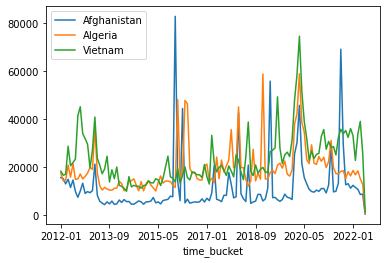

22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_15 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_51 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_29 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_33 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_47 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_41 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_18 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_19 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_36 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_2_42 !
22/07/11 16:02:48 WARN BlockManagerMasterEndpoint: No more replicas av

In [5]:
pd_df.plot(x='time_bucket', y=["Afghanistan", "Algeria", "Vietnam"])